# Interpolação

Dado um conjunto de n pontos $(x_i, y_i)$, qual o poliômio que passa por todos?

$$
y_i = a_0 + a_1 x_i + a_2 x_i^2 + \ldots a_n x_i^n \qquad i=1, \ldots, m
$$

## Vandermonde

Com n+1 pontos distintos, se o polinômio for de grau n, pode-se montar o seguinte sistema linear:

$$
\begin{bmatrix}
1 & x_0 & x_0^2 & \cdots & x_0^n \\
1 & x_1 & x_1^2 & \cdots & x_1^n \\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_n & x_n^2 & \cdots & x_n^n\\
\end{bmatrix}\cdot
\left\{ \begin{matrix} a_0 \\ a_1 \\ \vdots \\ a_n\\ \end{matrix}\right\}
= \left\{\begin{matrix} y_0 \\ y_1 \\ \vdots \\ y_n\\\end{matrix}\right\}
$$

Mas esta é uma operação cara, $\mathcal{O}(n^3)$!

## Outra possibilidade

$$
y = f(x) \approx a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + \cdots + a_n(x-x_0)(x-x_1)\cdots(x - x_{n-1})
$$

Com isso chegamos ao seguinte sistema linear triangular:
$$
\begin{bmatrix}
1 & 0 & 0 &  0 &\cdots & 0\\
1 & (x_1-x_0) & 0 & 0 &  \cdots & 0\\
1 & (x_2 - x_0) &  (x_2 - x_0)(x_2 - x_1) & 0 & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
1 & (x_n - x_0) &  (x_n - x_0)(x_n - x_1) & (x_n - x_0)(x_n - x_1)(x_n-x_2) & \cdots &(x_n-x_0)(x_n-x_1)\cdots(x_n-x_{n-1})\\
\end{bmatrix}\cdot\left\{\begin{matrix} a_0\\ a_1 \\ a_2 \\ \vdots \\ a_n\end{matrix}\right\} = 
\left\{\begin{matrix} y_0\\ y_1 \\ y_2 \\ \vdots \\ y_n\end{matrix}\right\}
$$

Resolver este sistema é muito mais barato: $\mathcal{O}(n^2)$

## Interpolação de Lagrange:

$$
y(x) = \sum_{i=1}^n y_i h_i(x)
$$

onde $h_i(x)$ é o interpolador de Lagrange:

$$
h_k(x) = \prod_{i=1\ldots n,}^n \frac{x - x_i}{x_k - x_i} \qquad i\ne k
$$

Propriedade:
$$
h_i(x_i) = \delta_{ij} \quad \text{onde} \quad \delta_{ij} = \left\{\begin{matrix}1, \: i=j \\ 0, i\ne j\\ \end{matrix}\right.
$$

### Vamos organizar a interpolação de Lagrange

In [1]:
struct Lagrange
    x::Vector{Float64}
    y::Vector{Float64}
    Lagrange(x, y) = new(copy(x), copy(y))
end
Base.Broadcast.broadcastable(lgr::Lagrange) = Ref(lgr)

function lagrange(k, z, x)
 h = 1.0
    n = length(z)
    for i = 1:(k-1)
        h *= (x - z[i]) / (z[k] - z[i])
    end
    
    for i = (k+1):n
        h *= (x - z[i]) / (z[k] - z[i])
    end
    return h
end

function interp(lgr::Lagrange, x)
    
    y = lgr.y[1] * lagrange(1, lgr.x, x)
    
    for i = 2:length(lgr.x)
        y += lgr.y[i] * lagrange(i, lgr.x, x)
    end
    
    return y
end

    
(lgr::Lagrange)(x) = interp(lgr, x)    

## Interpolação Linear



In [2]:
struct LinearInterp
    x::Vector{Float64}
    y::Vector{Float64}
    LinearInterp(x, y) = new(copy(x), copy(y))
end
Base.Broadcast.broadcastable(lin::LinearInterp) = Ref(lin)

function interp1(lin::LinearInterp, x)
    
    if x < lin.x[1] || x > lin.x[end]
        error("Fora do Range")
    end
    
    index = 2
    n = length(lin.x)
    for i = 2:n
        if lin.x[i] >= x
            index = i
            break
        end
    end
    i1 = index-1
    return lin.y[i1] + (lin.y[index] - lin.y[i1]) * (x - lin.x[i1]) / (lin.x[index] - lin.x[i1])
    
end
    
function interp2(lin::LinearInterp, x)
    index = searchsortedfirst(lin.x, x)
    if index == 1
        index = 2
    end
    i1 = index-1
    return lin.y[i1] + (lin.y[index] - lin.y[i1]) * (x - lin.x[i1]) / (lin.x[index] - lin.x[i1])
    
end

(lin::LinearInterp)(x) = interp1(lin, x)


# Pacotes

 * [Interpolations](https://github.com/JuliaMath/Interpolations.jl)
 * [Dierckx](https://github.com/kbarbary/Dierckx.jl)
 * [GridInterpolations](https://github.com/sisl/GridInterpolations.jl)

## Exercícios

### Problema 1

Interpole a função de Runge com $-1 \le x \le 1$:
$$
f(x) = \frac{1}{1 + 25x^2}
$$

 1. Use 11 pontos uniformemente distribuídos
 2. Aumente o número de pontos
 3. Tente usar os pontos $x_k = \cos\left(\frac{k\pi}{N}\right)$ para $k = 0\ldots N$.
 4. Brinque com o número de pontos

### Problema 2

Procure na Net o método de diferenças divididas de Newton a interpole a função anterior nos mesmos pontos. Este método é simplesmente um jeito inteligente de resolver a matriz apresentada lá em cima.

### Problema 3

Use a biblioteca Interpolations.jl e Dierckx.jl para fazer as interpolações. Compare a interpolação linear com os splines.



In [99]:
using PyPlot
using BenchmarkTools
using LinearAlgebra

# Problema 1

In [18]:
f(x) = 1.0 / (1.0 + 25x^2)

xx = -1:0.001:1
yy = f.(xx)



f (generic function with 1 method)

## Pontos igualmente espaçados

In [36]:
function ploteqspacing(N, dx=0.001)
    xp = range(-1.0, 1.0, length=N)
    yp = f.(xp)
    lgr = Lagrange(xp, yp)
    x1 = -1:dx:1
    y1 = lgr.(x1)
    y0 = f.(x1)
    plot(xp, yp, "ro")
    plot(x1, y0, "r-")
    plot(x1, y1)    
end


ploteqspacing (generic function with 2 methods)

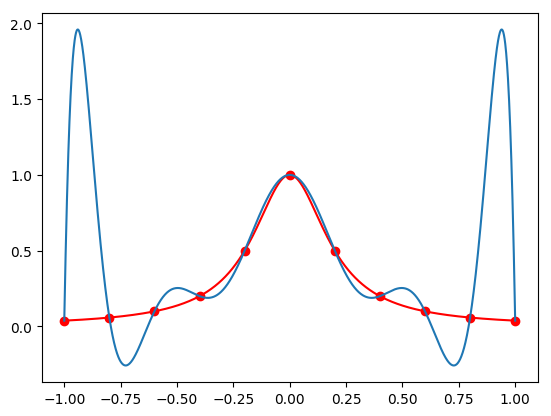

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92ccc1ca58>

In [37]:
ploteqspacing(11)


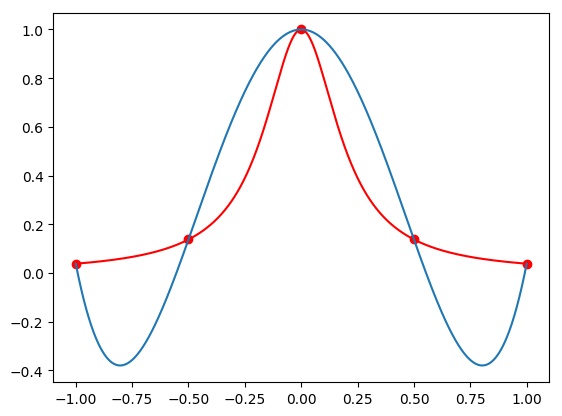

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92ccb4eac8>

In [38]:
ploteqspacing(5)

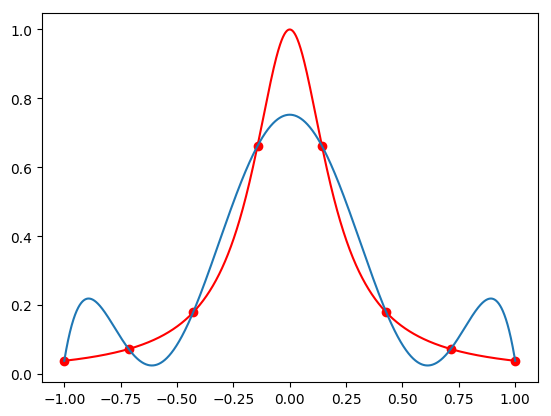

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cca5c978>

In [39]:
ploteqspacing(8)

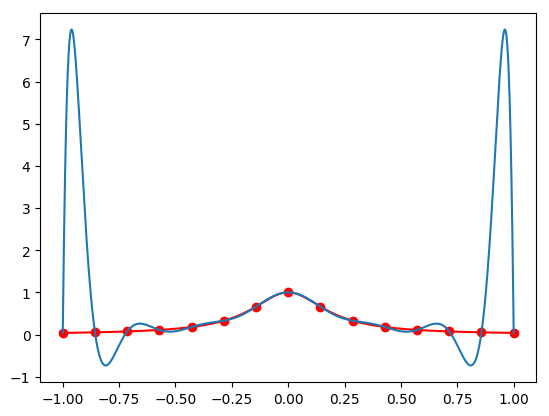

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc9d8eb8>

In [40]:
ploteqspacing(15)

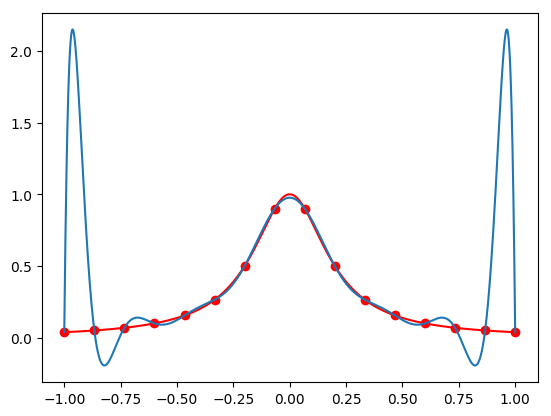

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc8f70b8>

In [41]:
ploteqspacing(16)

## Distribuição do cosseno


In [42]:
function plotcosspacing(N, dx=0.001)
    xp = [cos(k*π/N) for k in 0:N]
    yp = f.(xp)
    lgr = Lagrange(xp, yp)
    x1 = -1:dx:1
    y1 = lgr.(x1)
    y0 = f.(x1)
    plot(xp, yp, "ro")
    plot(x1, y0, "r-")
    plot(x1, y1)    
end

plotcosspacing (generic function with 2 methods)

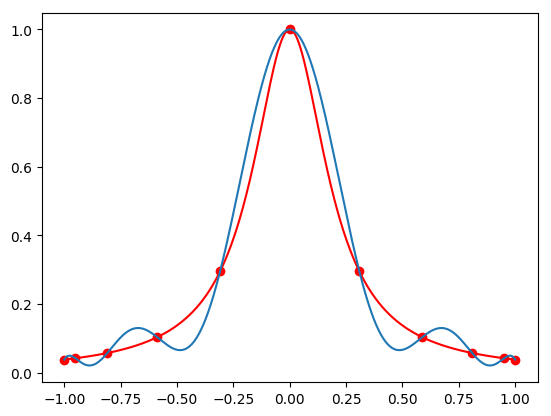

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc8e5c50>

In [44]:
plotcosspacing(10)

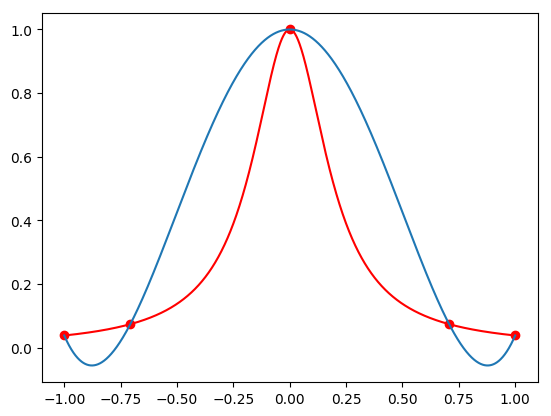

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92d38e6710>

In [46]:
plotcosspacing(4)

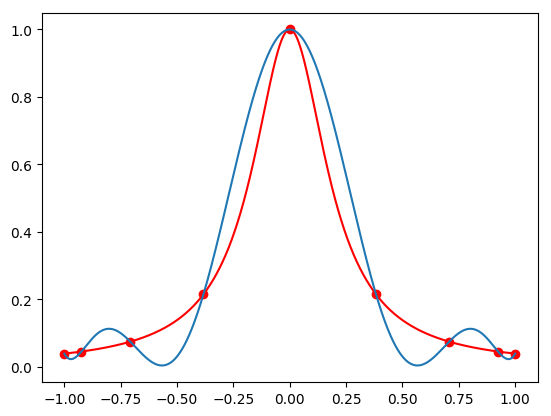

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc65ec50>

In [47]:
plotcosspacing(8)

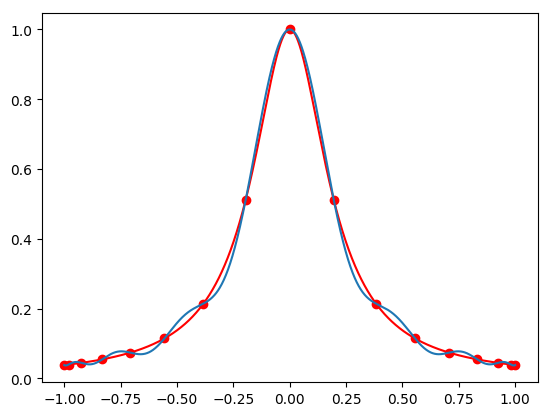

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc5e61d0>

In [48]:
plotcosspacing(16)

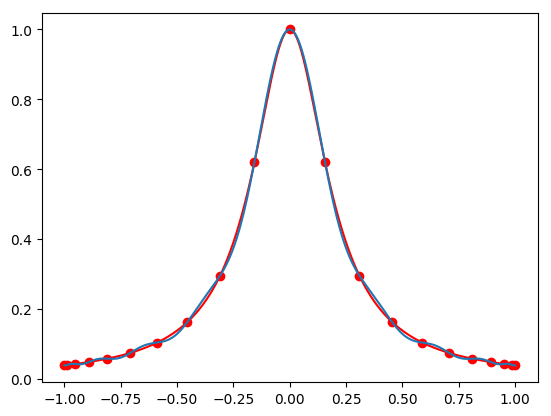

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92cc563710>

In [49]:
plotcosspacing(20)

## Problema 2

Diferenças divididas

In [105]:
function divdiffmat(x)
    n = length(x)
    
    A = zeros(n,n)
    for i = 1:n
        A[i,1] = 1.0
        for k in 2:i
            A[i, k] = A[i,k-1] * (x[i] - x[k-1])
        end
    end
    
    return A
    
end


divdiffmat (generic function with 2 methods)

In [153]:
struct DividedDiff
    x::Vector{Float64}
    a::Vector{Float64}
    function DividedDiff(x, y)
        A = LowerTriangular(divdiffmat(x))
        a = A\y
        return new(copy(x), a)
    end
end
Base.Broadcast.broadcastable(ddif::DividedDiff) = Ref(ddif)

function interp(ddif, x)
    xx = ddif.x
    a = ddif.a
    
    y = a[end] 
    
    for i in (lastindex(a)-1):-1:1
        y += a[i] + y*(x-xx[i])
    end
    return y
end
(ddif::DividedDiff)(x) = interp(ddif, x)

In [157]:
x = -1:0.4:1
y = sin.(π*x);

In [158]:
diff = DividedDiff(x, y)

DividedDiff([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0], [-1.22465e-16, -2.37764, 4.10727, -1.30737, -1.8271, 1.8271])

In [160]:

y1 = diff.(x)

6-element Array{Float64,1}:
 -1.2246467991473532e-16
  0.9549555391042407    
  0.5659550824061872    
 -0.26581748299851315   
  3.8511014957816343    
 25.043595320331946     

In [161]:
collect(x)

6-element Array{Float64,1}:
 -1.0
 -0.6
 -0.2
  0.2
  0.6
  1.0

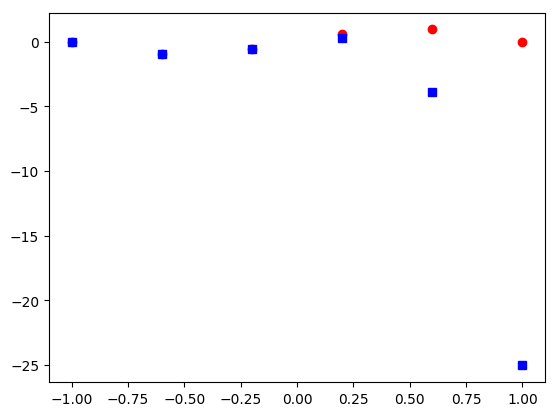

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f92c9916358>

In [162]:
plot(x, y, "ro")
plot(x, -y1, "bs")

In [137]:
diff.x

11-element Array{Float64,1}:
 -1.0
 -0.8
 -0.6
 -0.4
 -0.2
  0.0
  0.2
  0.4
  0.6
  0.8
  1.0